# Compare $I$ and $E$

In [1]:
import torch
import numpy as np
import math
import time

from newEGCcalculator import NormalG, Heteros, Inew, trainI

In [2]:
Nr = 32
Ns = 16
num_rho = 512

num_R = 4
R_span = torch.ones(num_R,Nr)
R_span[:,0] = torch.tensor([20.0,10.0,5.0,1.0])
R_span = (torch.sum(R_span,1)**(-1)).unsqueeze(1) * R_span * Nr

rho_span = torch.zeros(num_rho)
rho_span[:int(num_rho/2)] = torch.linspace(0, .869, steps=int(num_rho/2))
rho_span[int(num_rho/2):] = torch.linspace(.87, 1, steps=int(num_rho/2))

outputs = torch.zeros(num_R,num_rho,3)

In [ ]:
GGdiss_mean = torch.zeros(num_R)
for i in range(num_R):
    Rs = R_span[i]
    for j in range(num_rho):
        rho = rho_span[j]
        sample = torch.rand(Ns,2,Nr)
        L = torch.tensor([[1, 0],
                        [rho, math.sqrt(1-rho**2)]]) # Cholesky decomposition

        sample = torch.matmul(L,sample)

        G = sample[0:Ns,0]
        C = sample[0:Ns,1] # C has not been pushed away
        C = C @ torch.diag(0.9 + 0.1*torch.rand(Nr))
        
        V = C * Rs.unsqueeze(0)
        Ss = 0.01 + 0.99*torch.rand(Ns)

        Jstar = torch.zeros(Ns+Nr,Ns+Nr)
        Jstar[0:Ns,Ns:Ns+Nr] = torch.diag(Ss) @ G
        Jstar[Ns:Ns+Nr,0:Ns] = - torch.diag(Rs) @ C.transpose(0,1)
        Jstar[Ns:Ns+Nr,Ns:Ns+Nr] = - torch.diag(C.transpose(0,1) @ Ss)

        E_J = torch.linalg.eigvals(Jstar).real

        outputs[i,j,0] = len(E_J[E_J >= 1.0e-6])/Ns
        
        NG = NormalG(G)
        GGdiss = Heteros(G)
        #GGdiss_mean[i] += torch.mean(GGdiss)
        Imean, _ = Inew(NG,V,GGdiss)
        outputs[i,j,1] = Imean

        outputs[i,j,2],_ = trainI(G,C)

#GGdiss_mean = GGdiss_mean/num_rho

In [ ]:
unstable = (outputs[:,:,0] > 0).float()

In [ ]:
figout = {'I0':[], 'I1':[], 'I2':[], 'I3':[],
          'E0':[], 'E1':[], 'E2':[], 'E3':[]}

for ii in range(4):
    Is = torch.tensor([])
    if ii == 0:
        gridwidth = 0.2
    else:
        gridwidth = 0.1

    for i in range(100):
        indeces = ((i*gridwidth <=outputs[ii,:,1]) & (outputs[ii,:,1]<(i+1)*gridwidth)).nonzero(as_tuple=True)
        x_group = (outputs[ii,:,1])[indeces]
        y_group = unstable[ii][indeces]
        if x_group.size() != torch.Size([0]):
            Is = torch.cat((Is,
                    torch.tensor([torch.mean(x_group), torch.std(x_group)/math.sqrt(len(x_group)), 
                                    torch.mean(y_group), torch.std(y_group)/math.sqrt(len(y_group))]).unsqueeze(0)),0)
            
    Es = torch.tensor([])
    for i in range(60):
        indeces = ((i*0.1<=outputs[ii,:,2]) & (outputs[ii,:,2]<(i+1)*0.1)).nonzero(as_tuple=True)
        x_group = (outputs[ii,:,2])[indeces]
        y_group = unstable[ii][indeces]
        if x_group.size() != torch.Size([0]):
            Es = torch.cat((Es,
                    torch.tensor([torch.mean(x_group), torch.std(x_group)/math.sqrt(len(x_group)), 
                                    torch.mean(y_group), torch.std(y_group)/math.sqrt(len(y_group))]).unsqueeze(0)),0)
            
    intm = torch.nan_to_num(Is)
    Es = torch.nan_to_num(Es)
    figout['I'+str(ii)].append(Is)
    figout['E'+str(ii)].append(Es)

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

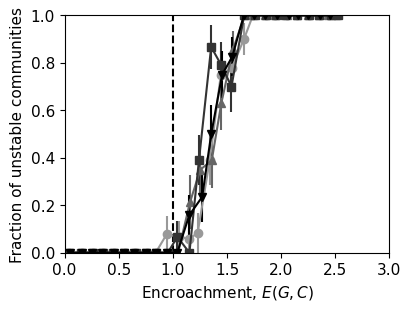

In [ ]:
plt.figure(figsize=(4, 3), constrained_layout=True)
makers = ['o','^','s','v']
colors = ['0.6','0.4','0.2','0']

for ii in range(4):
    plt.errorbar(figout['E'+str(ii)][0][:,0],figout['E'+str(ii)][0][:,2],
                 xerr=figout['E'+str(ii)][0][:,1], yerr= figout['E'+str(ii)][0][:,3],lw=1.5,marker=makers[ii], color= colors[ii]) # ls = 'none'
    
#plt.legend(['R 1','R 2','R 3','R 4'])
plt.plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), 'k--')
plt.xlim(0.0,3.0)
plt.ylim(0.,1.0)
plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Fraction of unstable communities')
plt.savefig('../figures/Figure3emb1v1.eps',format='eps')

Text(0, 0.5, 'Fraction of unstable communities')

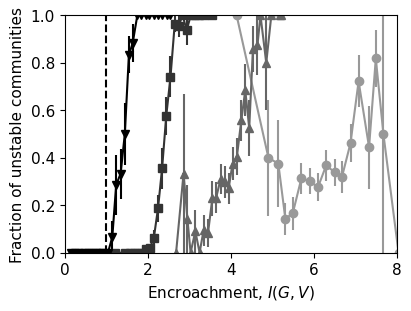

In [ ]:
plt.figure(figsize=(4, 3), constrained_layout=True)
makers = ['o','^','s','v']
for ii in range(4):
    plt.errorbar(figout['I'+str(ii)][0][:,0],figout['I'+str(ii)][0][:,2], 
                 xerr=figout['I'+str(ii)][0][:,1], yerr= figout['I'+str(ii)][0][:,3],lw=1.5,marker=makers[ii], color= colors[ii])

#plt.legend(['R 1','R 2','R 3','R 4'])
plt.plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), 'k--')
plt.xlim(0.0,8.0)
plt.ylim(0.,1.0)
plt.xlabel('Encroachment, $I(G,V)$')
plt.ylabel('Fraction of unstable communities')
#plt.savefig('../figures/Figure3emb2.eps',format='eps')

In [4]:
from pathlib import Path
datapath = Path('./data/').expanduser()
loaded = torch.load(datapath/'torch_test')
loaded1 = torch.load(datapath/'LinlogJ.pt')
Outputs = loaded['Outputs']
Ns_span = loaded['Ns_span']
rho_span = loaded['rho_span']
Nr = loaded['Nr']
num_try = Outputs.size(dim = 1)

datapath = Path('./data/Jun11/').expanduser()
Fractions = (torch.load(datapath/'allFractions')['Fractions']).transpose(0,1).transpose(1,2).transpose(0,3)

In [5]:
x_mean = []
sur_mean = []
x_std = []
sur_std = []

for i in range(28):
    #indeces = ((i*0.05<=Outputs[2]) & (Outputs[2]<(i+1)*0.05)).nonzero(as_tuple=True)
    indeces = ((i*0.05<=Outputs[2,:,15,:]) & (Outputs[2,:,15,:]<(i+1)*0.05)).nonzero(as_tuple=True)
    x_group = Outputs[2,:,15,:][indeces] # 28 means Ns = Nr
    y_group = Fractions[0,:,15,:][indeces]
    if x_group.size() != torch.Size([0]):
        x_mean.append(torch.mean(x_group))
        x_std.append(torch.std(x_group)/math.sqrt(len(indeces[0])))
        sur_mean.append(torch.mean(y_group))
        sur_std.append(torch.std(y_group)/math.sqrt(len(indeces[0])))

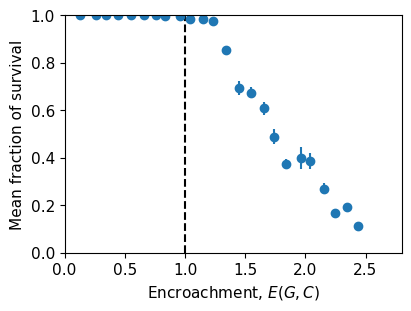

In [9]:
plt.figure(figsize=(4, 3),constrained_layout=True)
plt.errorbar(2*torch.tensor(x_mean),sur_mean, xerr=x_std, yerr= sur_std, marker = 'o', ls='none')
plt.plot(torch.linspace(1,1, steps=10),torch.linspace(.0,1.0, steps=10),'--k')
plt.xlim(.0,2.8)
plt.ylim(.0,1.0)
plt.xlabel('Encroachment, $E(G,C)$')
plt.ylabel('Mean fraction of survival')
plt.savefig('../figures/Figure3emb3.eps', format='eps')